In [192]:
#from tangostationcontrol.statistics_writer.statistics_writer import main
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
from os import listdir
from os.path import isfile,join
from time import sleep

In [193]:
datestr='2022-10-17'
SSTdate=datestr
#SSTdate='2022-10-16'

Dsat=np.load('C'+datestr+'.npz')
#Dsat=np.load(datestr+'.npz')
alts=Dsat['alts']
azs=Dsat['azs']
sat_names=Dsat['sat_names']
Nsat=len(sat_names)
Ntime=len(alts[0])
Satstep=int(24*60*60/Ntime)
print("Timestep: %is, nstep=%i"%(Satstep,Ntime))
#start_time = Time(datestr+' 00:00:00') #- utcoffset
#delta_time = np.linspace(0, 24, 15*24*4*6)*u.hour #15*24*2
#times=start_time+delta_time
#print(len(delta_time))
print(sat_names)

Timestep: 10s, nstep=8640
['NOAA 15' 'NOAA 18' 'NOAA 19' 'METEOR-M 2']


In [194]:
sat_freq=[137.62,137.9,137.1,137.1]
print("Sat freq (MHz):",sat_freq)

freqs=200-np.arange(512)/512*100
sat_band=np.array([np.argmin(np.abs(freqs-freq1)) for freq1 in sat_freq])
print("Sat bands:",sat_band)
bmin=np.min(sat_band)
bmax=np.max(sat_band)+1

Sat freq (MHz): [137.62, 137.9, 137.1, 137.1]
Sat bands: [319 318 322 322]


In [195]:
dhours=[]
dcnt=[]
#opath='xst_mean'
fpath='sst2'
if True:
    files=listdir(fpath)#[f for f in listdir(fpath)];
    files.sort()
    files = [f for f in files if isfile(join(fpath,f)) and (f[-4:]=='.npy') and (f[:14]=='SST_'+SSTdate)]
    print(len(files),files[0])
for i,f in enumerate(files):
    print(i,f)
#tmin=int(files[0][18:18+2])
#tsec=int(files[0][21:21+2])
#print(tmin,tsec)
tsec=int(files[0][18:18+2])*60+int(files[0][21:21+2])
print("time offset %is"%tsec)

11 SST_2022-10-17-15-24-56.npy
0 SST_2022-10-17-15-24-56.npy
1 SST_2022-10-17-15-29-40.npy
2 SST_2022-10-17-15-31-53.npy
3 SST_2022-10-17-16-31-53.npy
4 SST_2022-10-17-17-31-53.npy
5 SST_2022-10-17-18-31-53.npy
6 SST_2022-10-17-19-31-53.npy
7 SST_2022-10-17-20-31-53.npy
8 SST_2022-10-17-21-31-53.npy
9 SST_2022-10-17-22-31-53.npy
10 SST_2022-10-17-23-31-53.npy
time offset 1496s


In [196]:
freqs=200-np.arange(512)/512*100
freq1=137;i2=np.argmin(np.abs(freqs-freq1))
freq2=138;i1=np.argmin(np.abs(freqs-freq2))
print(bmin,bmax,freqs[bmin],freqs[bmax-1])

318 323 137.890625 137.109375


In [197]:
D=[]
flist=[]
for f in files[:]:
  print(f)
  D2=np.load(fpath+'/'+f)[:,18:,bmin:bmax]
  ns=D2.shape
#  print(ns)
  if ns[0]!=3600: continue;
  D2=D2.reshape(ns[0]//Satstep,Satstep,ns[1],ns[2])
  D2=np.average(D2,axis=1)
  D.append(D2)
  flist.append(f)
  print("    ",D[-1].shape)
D=np.array(D)
print(D.shape)
ns=D.shape
D=D.reshape([ns[0]*ns[1],ns[2],ns[3]])
print(D.shape)


SST_2022-10-17-15-24-56.npy
SST_2022-10-17-15-29-40.npy
SST_2022-10-17-15-31-53.npy
     (360, 12, 5)
SST_2022-10-17-16-31-53.npy
     (360, 12, 5)
SST_2022-10-17-17-31-53.npy
     (360, 12, 5)
SST_2022-10-17-18-31-53.npy
     (360, 12, 5)
SST_2022-10-17-19-31-53.npy
     (360, 12, 5)
SST_2022-10-17-20-31-53.npy
     (360, 12, 5)
SST_2022-10-17-21-31-53.npy
     (360, 12, 5)
SST_2022-10-17-22-31-53.npy
     (360, 12, 5)
SST_2022-10-17-23-31-53.npy
     (360, 12, 5)
(9, 360, 12, 5)
(3240, 12, 5)


In [209]:
tcorr=6*60*0 #seconds error in FPGA time
from datetime import datetime
time0=datetime.strptime(flist[0][4:-4], '%Y-%m-%d-%H-%M-%S')
time1=datetime.strptime(flist[-1][4:-4], '%Y-%m-%d-%H-%M-%S')
print(time0,'-',time1)
ts0=(time0.hour*60*60+time0.minute*60+time0.second+tcorr)//Satstep
ts1=((time1.hour+1)*60*60+time1.minute*60+time1.second+tcorr)//Satstep
if ts1>Ntime: ts1=Ntime
print("First&last timestep:",ts0,ts1)
print("Steps=",ts1-ts0)
nsteps=ts1-ts0

2022-10-17 15:31:53 - 2022-10-17 23:31:53
First&last timestep: 5591 8640
Steps= 3049


In [210]:
D2=10*np.log10(np.abs(D))-80
#D2-=D2*(D2<0)
print(np.max(D2),np.min(D2))


29.606323 -13.462425


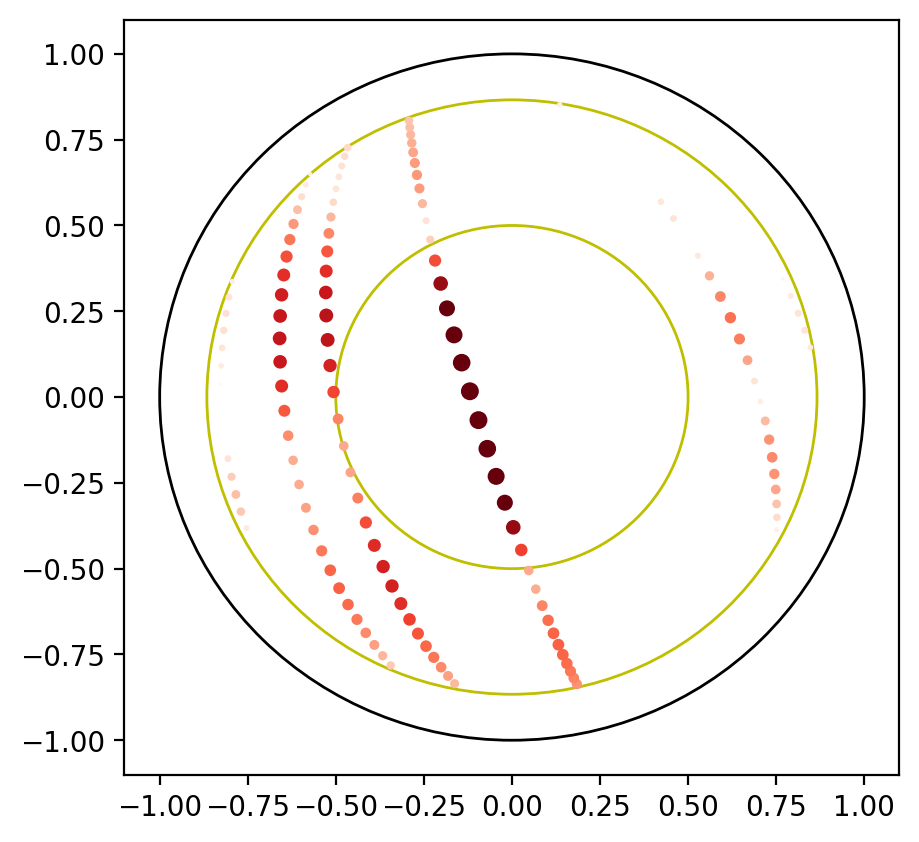

In [211]:
plt.figure(dpi=200,figsize=(5,5))
ax = plt.gca()
ax.add_patch(plt.Circle((0, 0), 1.0, color='k',fill=False))
ax.add_patch(plt.Circle((0, 0), 0.5, color='y',fill=False))
ax.add_patch(plt.Circle((0, 0), np.cos(30/180*np.pi), color='y',fill=False))
markers=['o','^','+','x','v','^']
for i in range(Nsat):
    az=np.array(azs[i][ts0:ts1])/180*np.pi
    alt=np.array(alts[i][ts0:ts1])/180*np.pi
#    mxalt=np.max(alt)
#    if mxalt<30./180*np.pi: continue
#    for hbat in range(0,2):
#    for hbat in [2,3,10,11]:
#    for hbat in [6,7]:
    for hbat in [0]:
     mask=(alt>30/180*np.pi)*(D2[:nsteps,hbat,sat_band[i]-bmin]>0)
     X=np.compress(mask, np.cos(alt)*np.sin(az) )
     Y=np.compress(mask, np.cos(alt)*np.cos(az))
     z=np.compress(mask, D2[:nsteps,hbat,sat_band[i]-bmin])
     plt.scatter(X,Y,s=z,c=z,cmap='Reds',marker=markers[hbat//2],vmin=0,vmax=20)


#plot = plt.scatter(x, y, s= 10, c = z, cmap='coolwarm')

In [212]:
rot=-15#-24-24#+24-70
pnts=[[90,0],[60,rot],[60,rot+90],[60,rot+180],[60,rot+270],[60,rot]]  #alt,az pairs in degrees

/tmp/ipykernel_812235/2973691592.py:22: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(X/mask,Y/mask,'k:',linewidth=0.3)
/tmp/ipykernel_812235/2973691592.py:22: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(X/mask,Y/mask,'k:',linewidth=0.3)
/tmp/ipykernel_812235/2973691592.py:22: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(X/mask,Y/mask,'k:',linewidth=0.3)
/tmp/ipykernel_812235/2973691592.py:22: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(X/mask,Y/mask,'k:',linewidth=0.3)
/tmp/ipykernel_812235/2973691592.py:22: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(X/mask,Y/mask,'k:',linewidth=0.3)
/tmp/ipykernel_812235/2973691592.py:22: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(X/mask,Y/mask,'k:',linewidth=0.3)
/tmp/ipykernel_812235/2973691592.py:22: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(X/mask,Y/mask,'k:',linewidth=0.3)

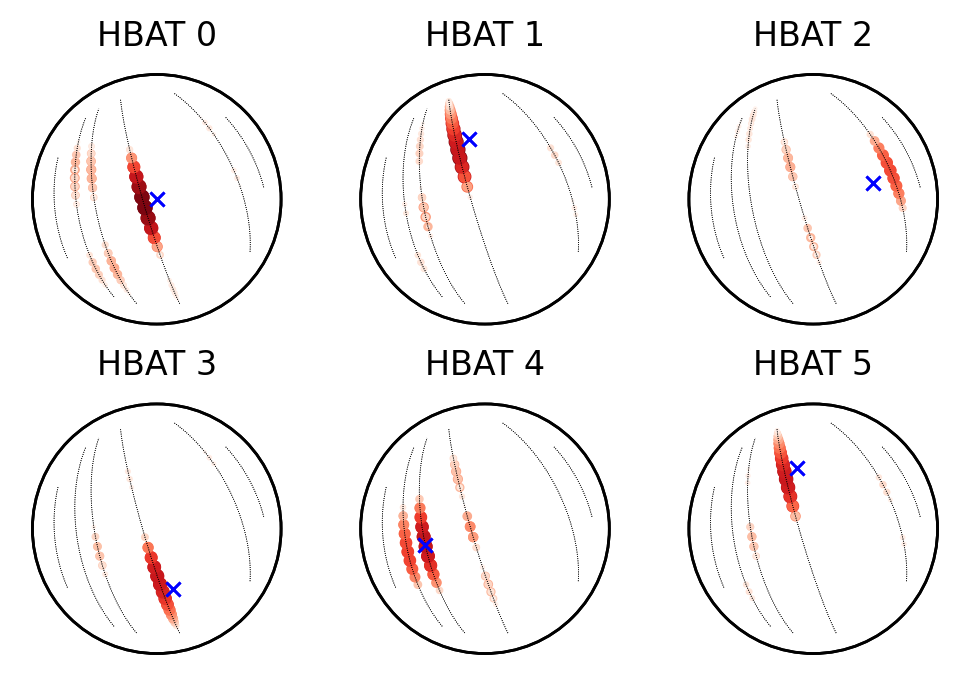

In [234]:
def XY(alt,az):
  X=np.cos(alt/180*np.pi)*np.sin(az/180*np.pi)
  Y=np.cos(alt/180*np.pi)*np.cos(az/180*np.pi)
  return X,Y

plt.figure(dpi=200,figsize=(6,4))
markers=['o','o']
for hbat in range(12):
  ax=plt.subplot(2, 3, hbat//2+1)
  ax = plt.gca()
  ax.add_patch(plt.Circle((0, 0), 1.0, color='k',fill=False))
#  ax.add_patch(plt.Circle((0, 0), 0.5, color='y',fill=False))
#  ax.add_patch(plt.Circle((0, 0), np.cos(30/180*np.pi), color='y',fill=False))
  plt.axis('off')
  plt.title('HBAT %i'%(hbat//2))
  for i in range(Nsat):
    az=np.array(azs[i][ts0:ts1])/180*np.pi
    alt=np.array(alts[i][ts0:ts1])/180*np.pi
    mask=(alt>30/180*np.pi)*1
    X=np.cos(alt)*np.sin(az)
    Y=np.cos(alt)*np.cos(az)
    plt.plot(X/mask,Y/mask,'k:',linewidth=0.3)
for hbat in range(12):
  ax=plt.subplot(2, 3, hbat//2+1)
  for i in range(Nsat):
    az=np.array(azs[i][ts0:ts1])/180*np.pi
    alt=np.array(alts[i][ts0:ts1])/180*np.pi
    mask=(alt>30/180*np.pi)*1
    X=np.cos(alt)*np.sin(az)
    Y=np.cos(alt)*np.cos(az)
    X=np.compress(mask, X )
    Y=np.compress(mask, Y)
    z=np.compress(mask, D2[:nsteps,hbat,sat_band[i]-bmin])
    mask=(alt>10/180*np.pi)*(D2[:nsteps,hbat,sat_band[i]-bmin]>0)
    plt.scatter(X,Y,s=z-9,c=z,cmap='Reds',marker=markers[hbat%2],vmin=9,vmax=30)
  X,Y = XY(pnts[hbat//2][0],pnts[hbat//2][1])
  plt.plot([X],[Y],'bx',markersize=5)
plt.savefig("sats2.jpg")
#plot = plt.scatter(x, y, s= 10, c = z, cmap='coolwarm')

In [176]:
#D=np.array(D)
#print(D.shape)
#ns=D.shape
#D=D.reshape([ns[0]*ns[1],ns[2],ns[3]])
#print(D.shape)

istart= 0 0.0
1 -57.507385 2064 5.733333333333333
2 -55.19371 2665 7.402777777777778
5 -45.989014 2967 8.241666666666667


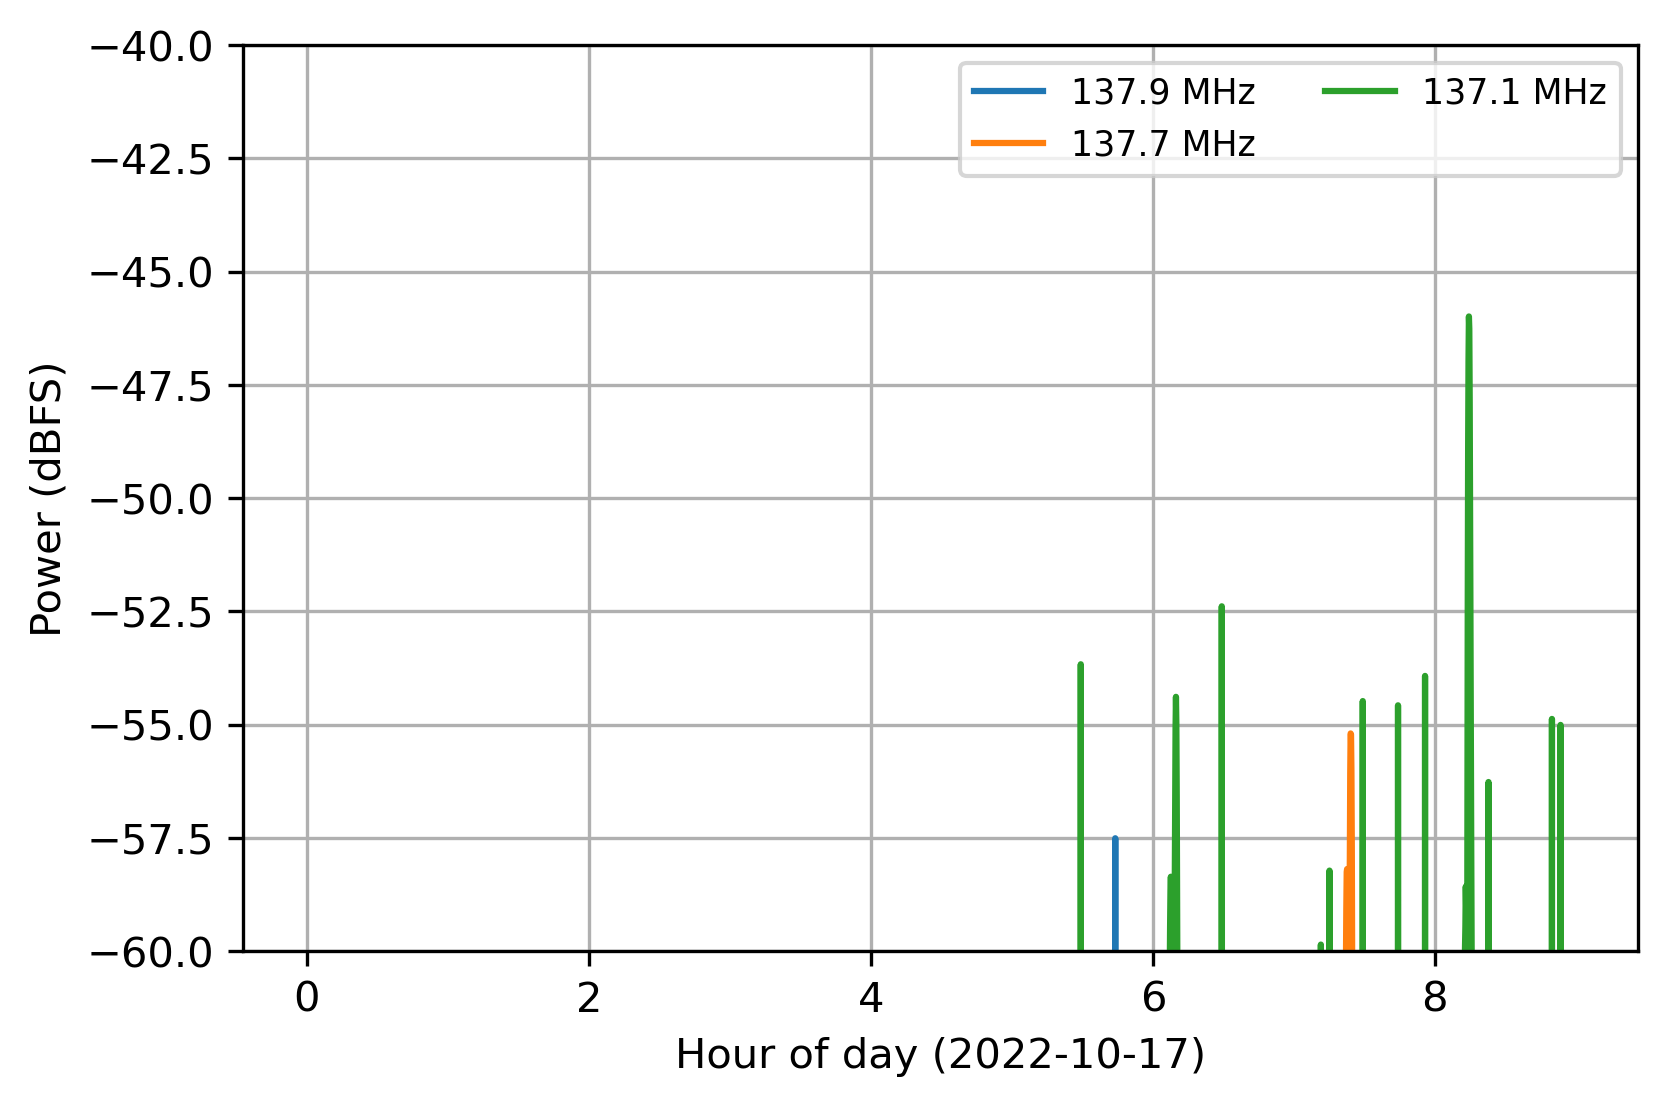

In [178]:
plt.figure(dpi=300)
GainADC=(10*np.log10(100e6)+20*np.log10(2**12)) #XST to dBFS
hour_of_day=np.arange(D.shape[0])/6/60
istart=0#20*360
istop=-1#int(21.6*360)
print("istart=",istart,istart/360)
for i in [1,2,5]:
#for i in range(6):
    Pwr=np.max(10*np.log10(D[istart:istop,:,i]),axis=1)-GainADC
    plt.plot(hour_of_day[istart:istop],Pwr,label='%.1f MHz' % (freqs[i1+i]));
    print(i,np.max(Pwr),istart+np.argmax(Pwr),(istart+np.argmax(Pwr))/360)
#plt.xlim(0,24)
plt.ylim(-60,-40)
plt.ylabel('Power (dBFS)')
plt.legend(fontsize='small',ncol=2)
plt.xlabel('Hour of day (%s)'%SSTdate)
plt.grid()

In [170]:
#14 okt
#ix=1333
#bnd=5
#ix=1238
#bnd=2

#15 okt
#ix=2457
#bnd=5
#ix=3110
#bnd=5
#ix=6487
#bnd=2
#ix=2968
#bnd=2
#ix=2457
#bnd=1
ix=7746
bnd=1

#16 okt
#ix=3039
#bnd=5
#ix=2817
#bnd=2
#ix=7679
#bnd=1
#ix=2336
#bnd=5

#17 okt
#ix=2665
#bnd=2

filenr=ix//360
ix2=(ix%360)*10
print(filenr,ix2)

21 1860


In [171]:
if True:
  f=flist[filenr]
  print(f)
  D2=np.load(fpath+'/'+f)[:,18:,i1:i2]


SST_2022-10-15-21-01-11.npy


(-2.0, 2.0)

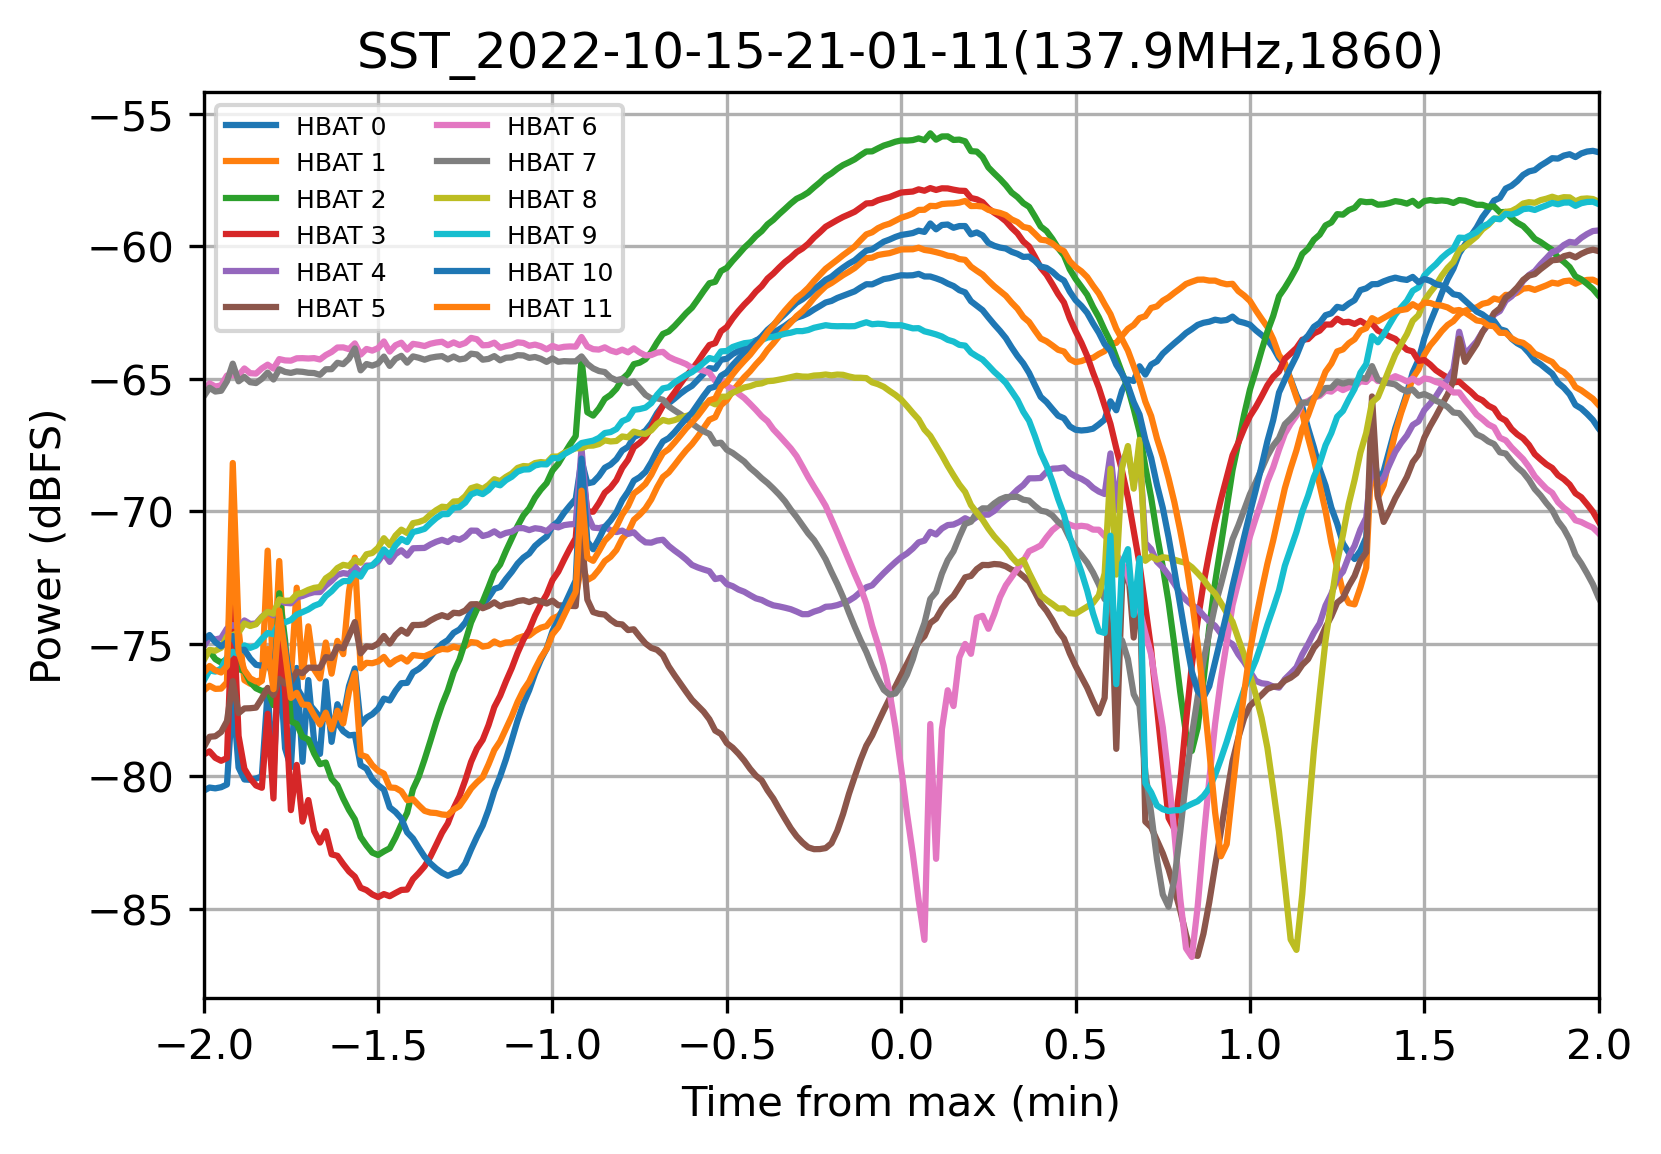

In [172]:
plt.figure(dpi=300)
GainADC=(10*np.log10(100e6)+20*np.log10(2**12)) #XST to dBFS
istart=200 if ix2>=200 else ix2
time_min=(np.arange(200+istart)-istart)/60
for x in range(0,12):
    plt.plot(time_min,10*np.log10(D2[ix2-istart:ix2+200,x,bnd])-GainADC,label='HBAT %i'%x);
#    plt.plot(10*np.log10(D2[:,x,bnd])-GainADC,label='HBAT %i'%x);
plt.grid()
#plt.xlim(-100,100)
plt.xlabel("Time from max (min)")
plt.ylabel("Power (dBFS)")
plt.legend(ncol=2,fontsize=6)
plt.title(flist[filenr][:-4]+("(%.1fMHz,%i)"%(freqs[i1+bnd],ix2)))
plt.xlim(-2,2)

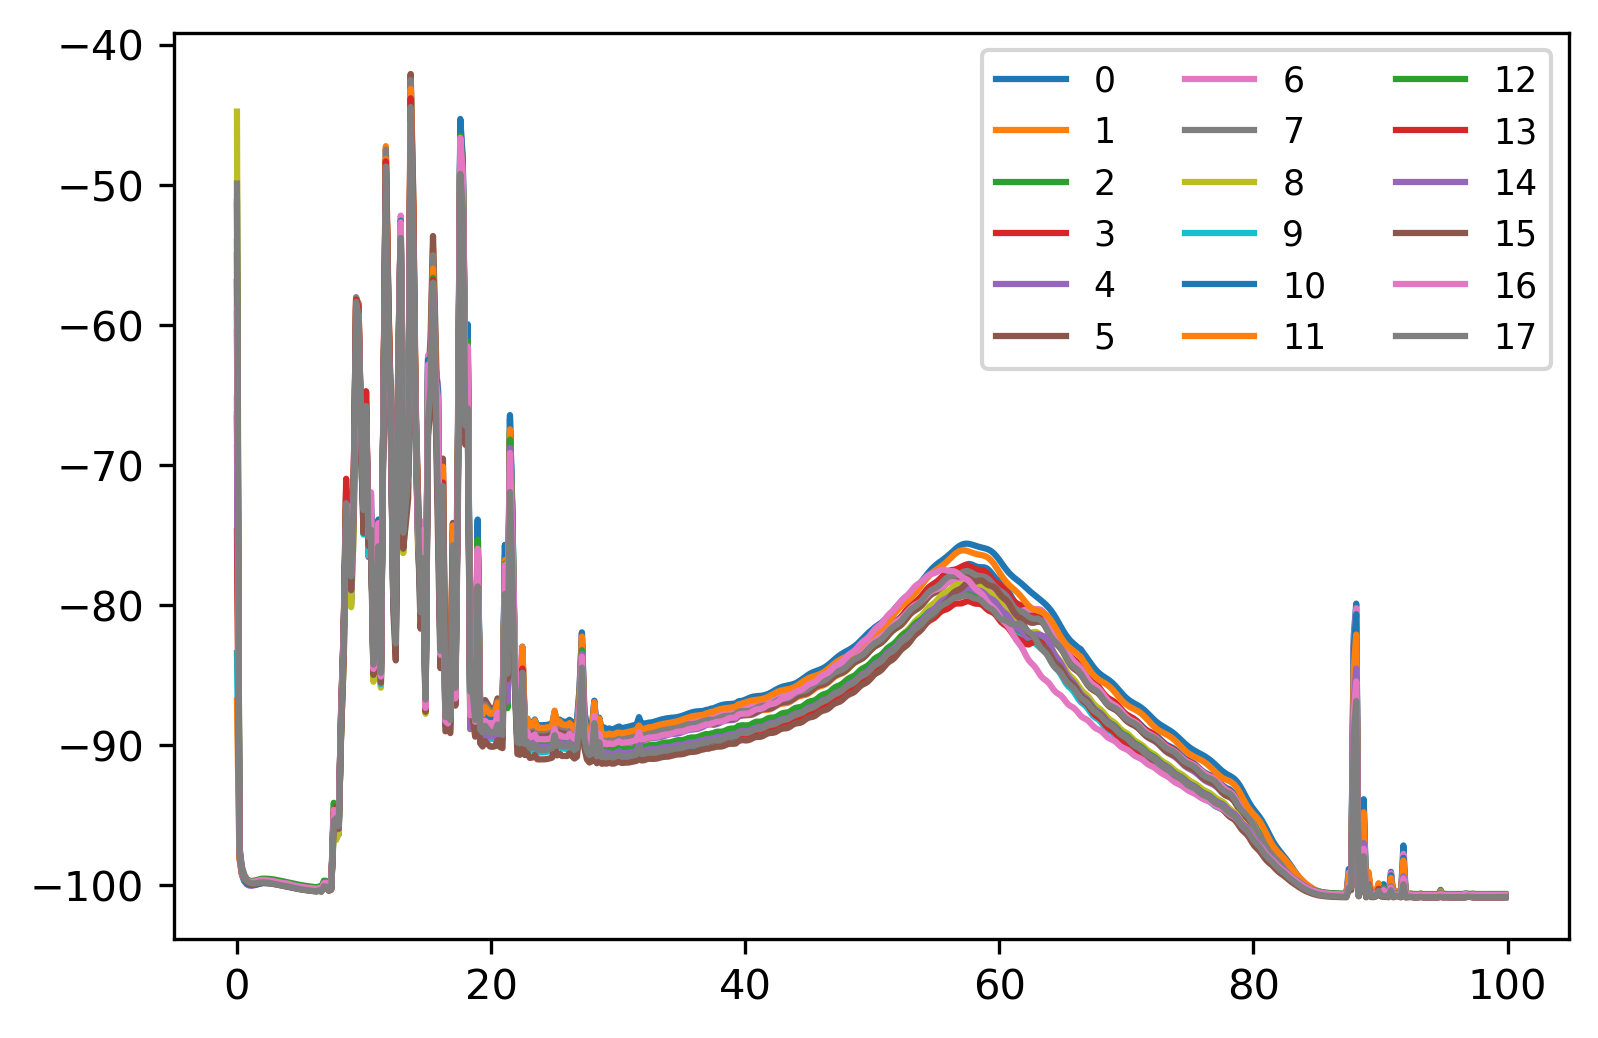

In [44]:
plt.figure(dpi=300)
Dm=np.percentile(D,50,axis=0)
freq=np.arange(512)/512*100
GainADC=(10*np.log10(100e6)+20*np.log10(2**12)) #XST to dBFS
for i,si in enumerate(sis):
    plt.plot(freq,10*np.log10(Dm[i])-GainADC,label=str(si))
plt.legend(fontsize='small',ncol=3)

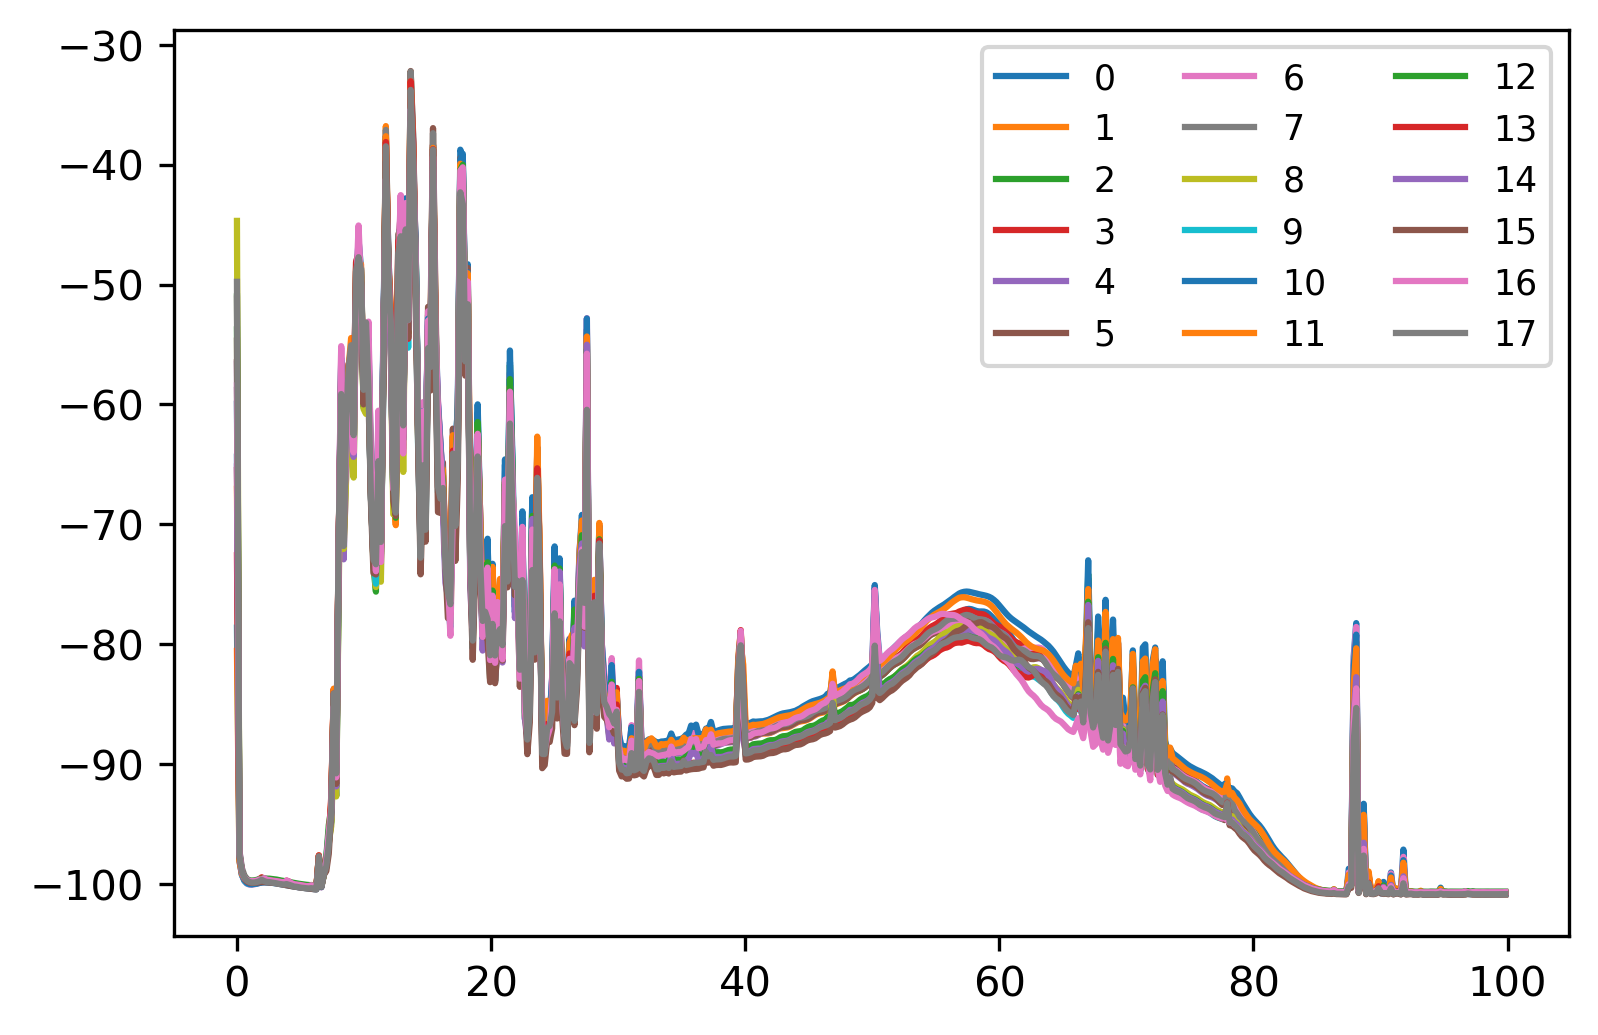

In [45]:
plt.figure(dpi=300)
Dm=np.max(D,axis=0)
freq=np.arange(512)/512*100
GainADC=(10*np.log10(100e6)+20*np.log10(2**12)) #XST to dBFS
for i,si in enumerate(sis):
    plt.plot(freq,10*np.log10(Dm[i])-GainADC,label=str(si))
plt.legend(fontsize='small',ncol=3)

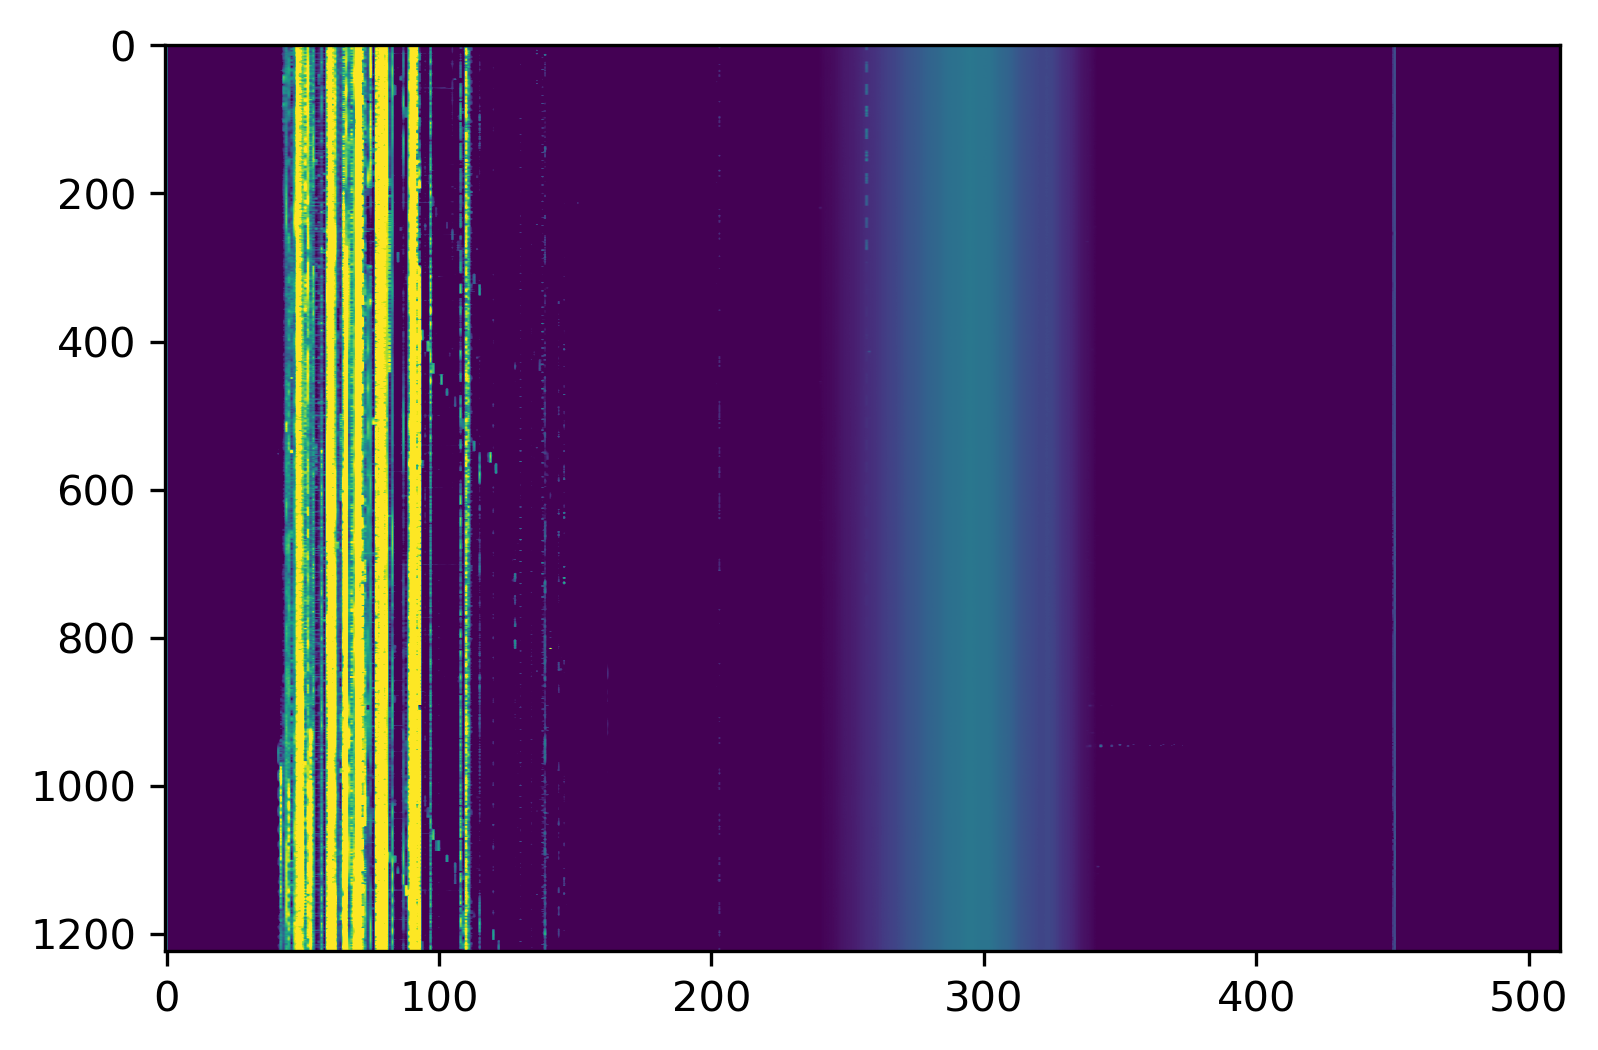

In [46]:
plt.figure(dpi=300)
plt.imshow(10*np.log10(D[:,0,:])-GainADC,aspect='auto',vmin=-85,vmax=-65)

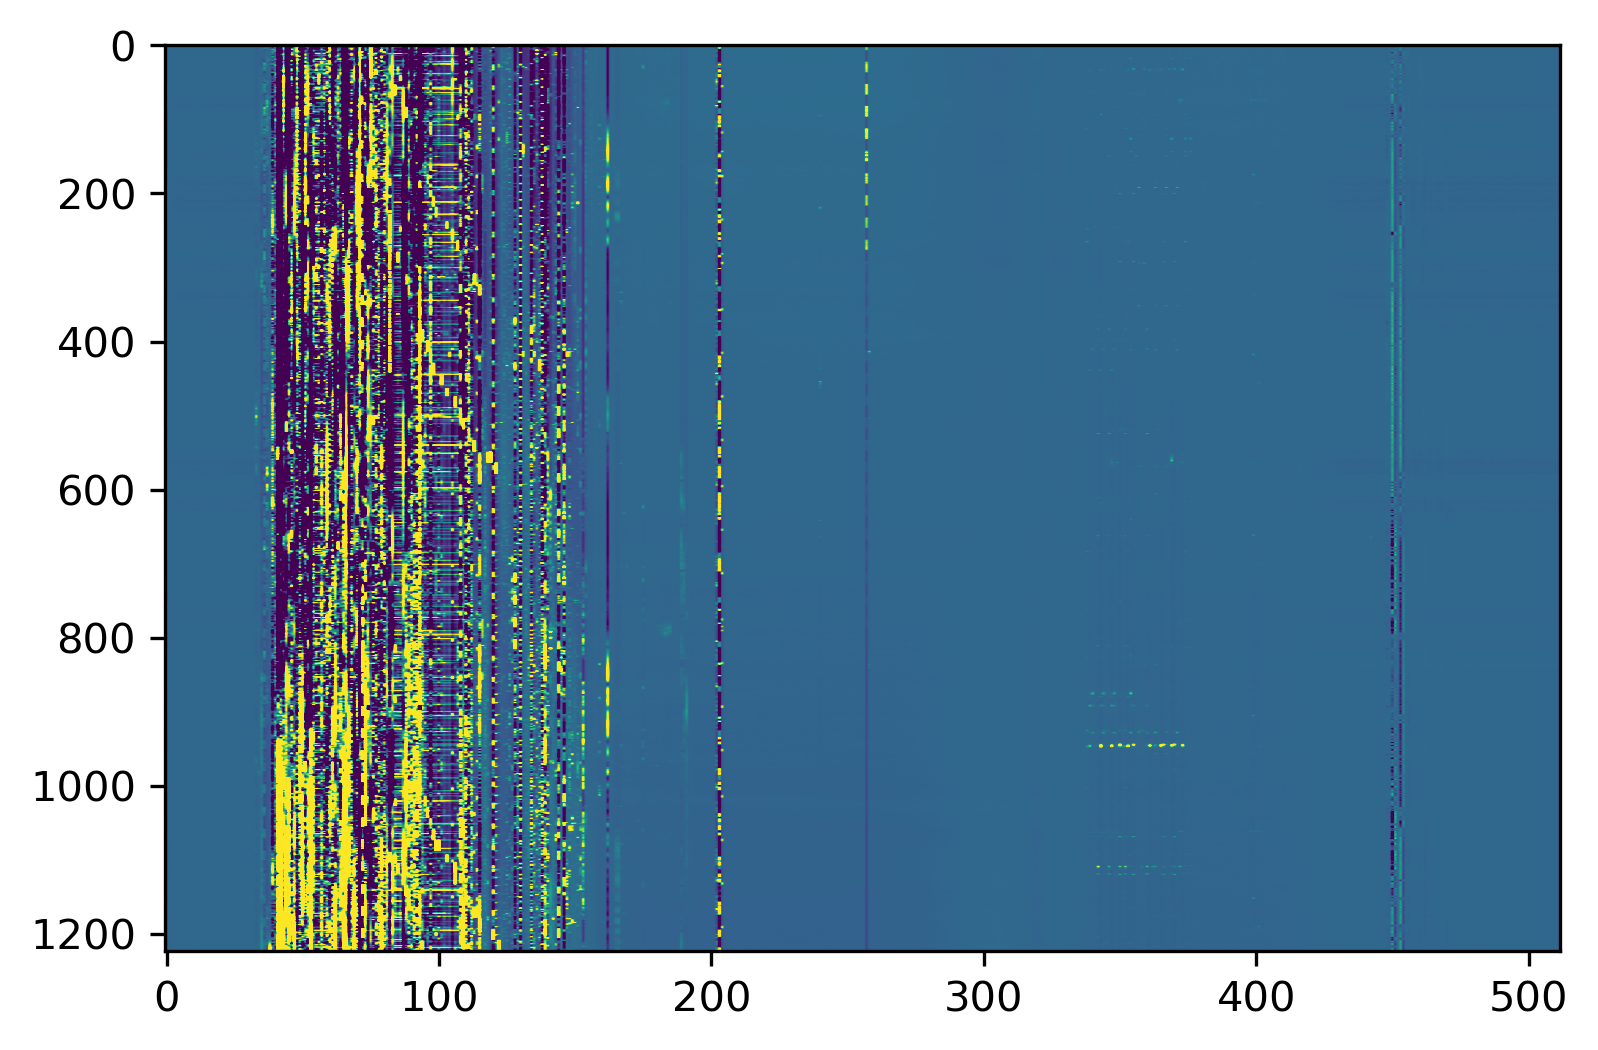

In [47]:
plt.figure(dpi=300)
XX=10*np.log10(D[:,:6,:]).mean(axis=1)
XX-=XX.mean(axis=0)

plt.imshow(XX,aspect='auto',vmin=-1,vmax=2)
#plt.xlim(150,450)
#plt.ylim(1500,2000)
#plt.colorbar()

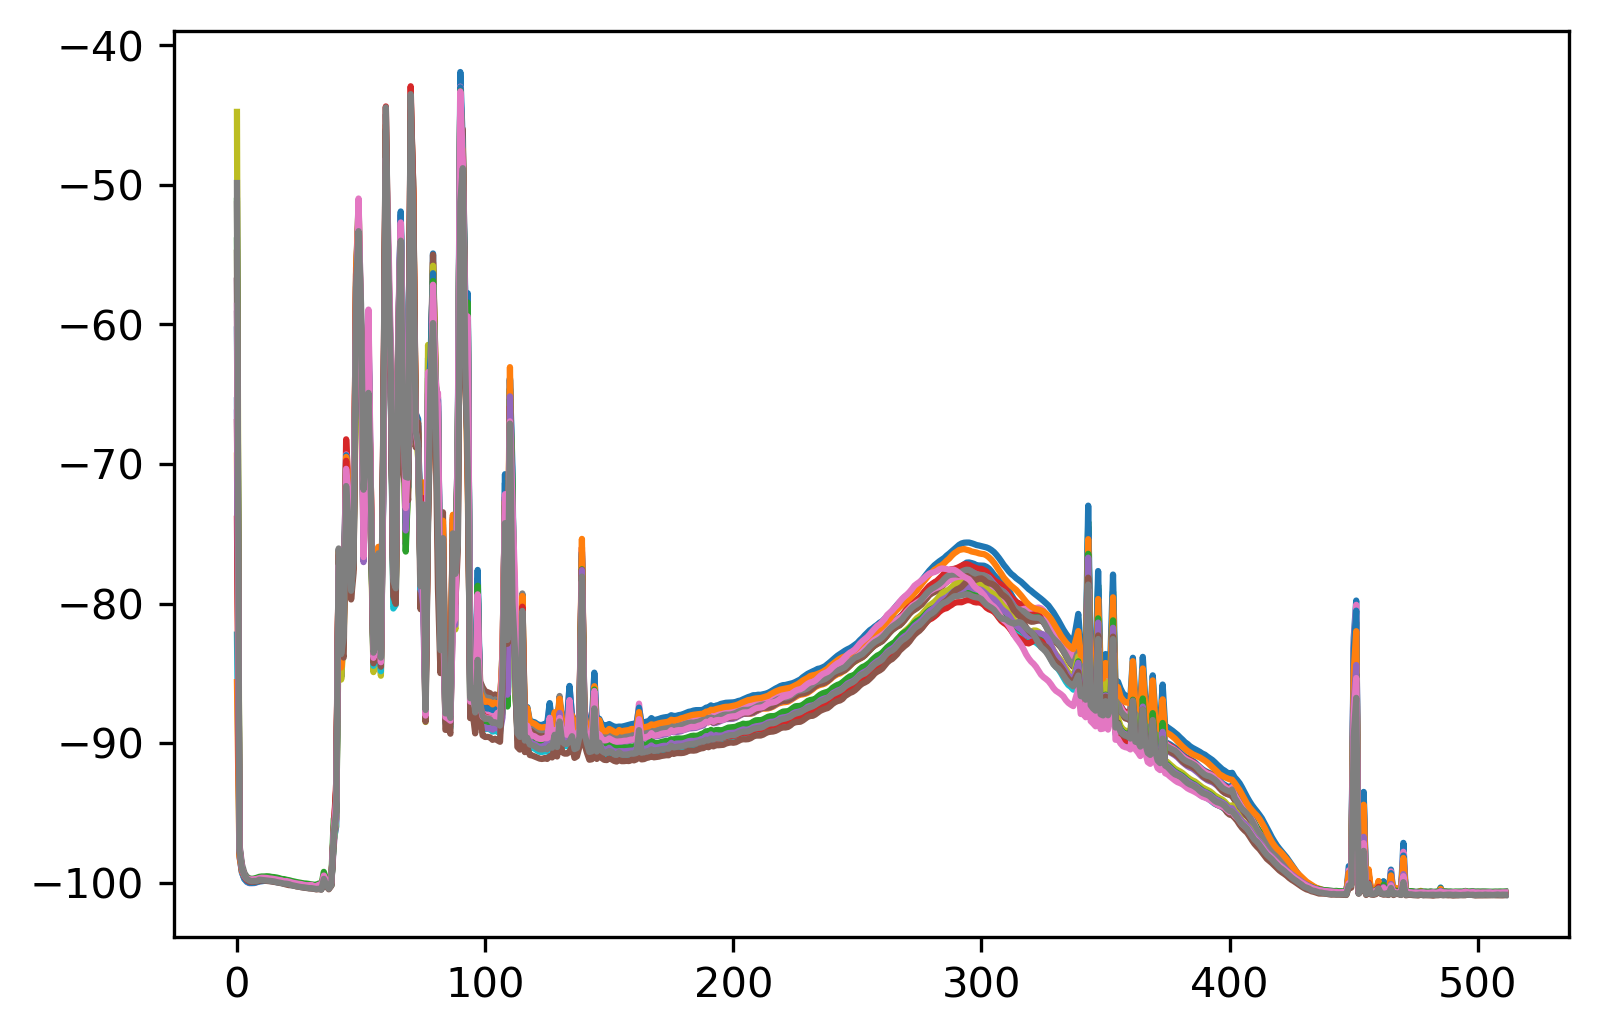

In [61]:
plt.figure(dpi=300)
plt.plot(10*np.log10(D[946,:,:]).T-GainADC);

/tmp/ipykernel_348197/2640272261.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10*np.log10(D[:,-1,:])-GainADC,aspect='auto',vmin=-85,vmax=-65)


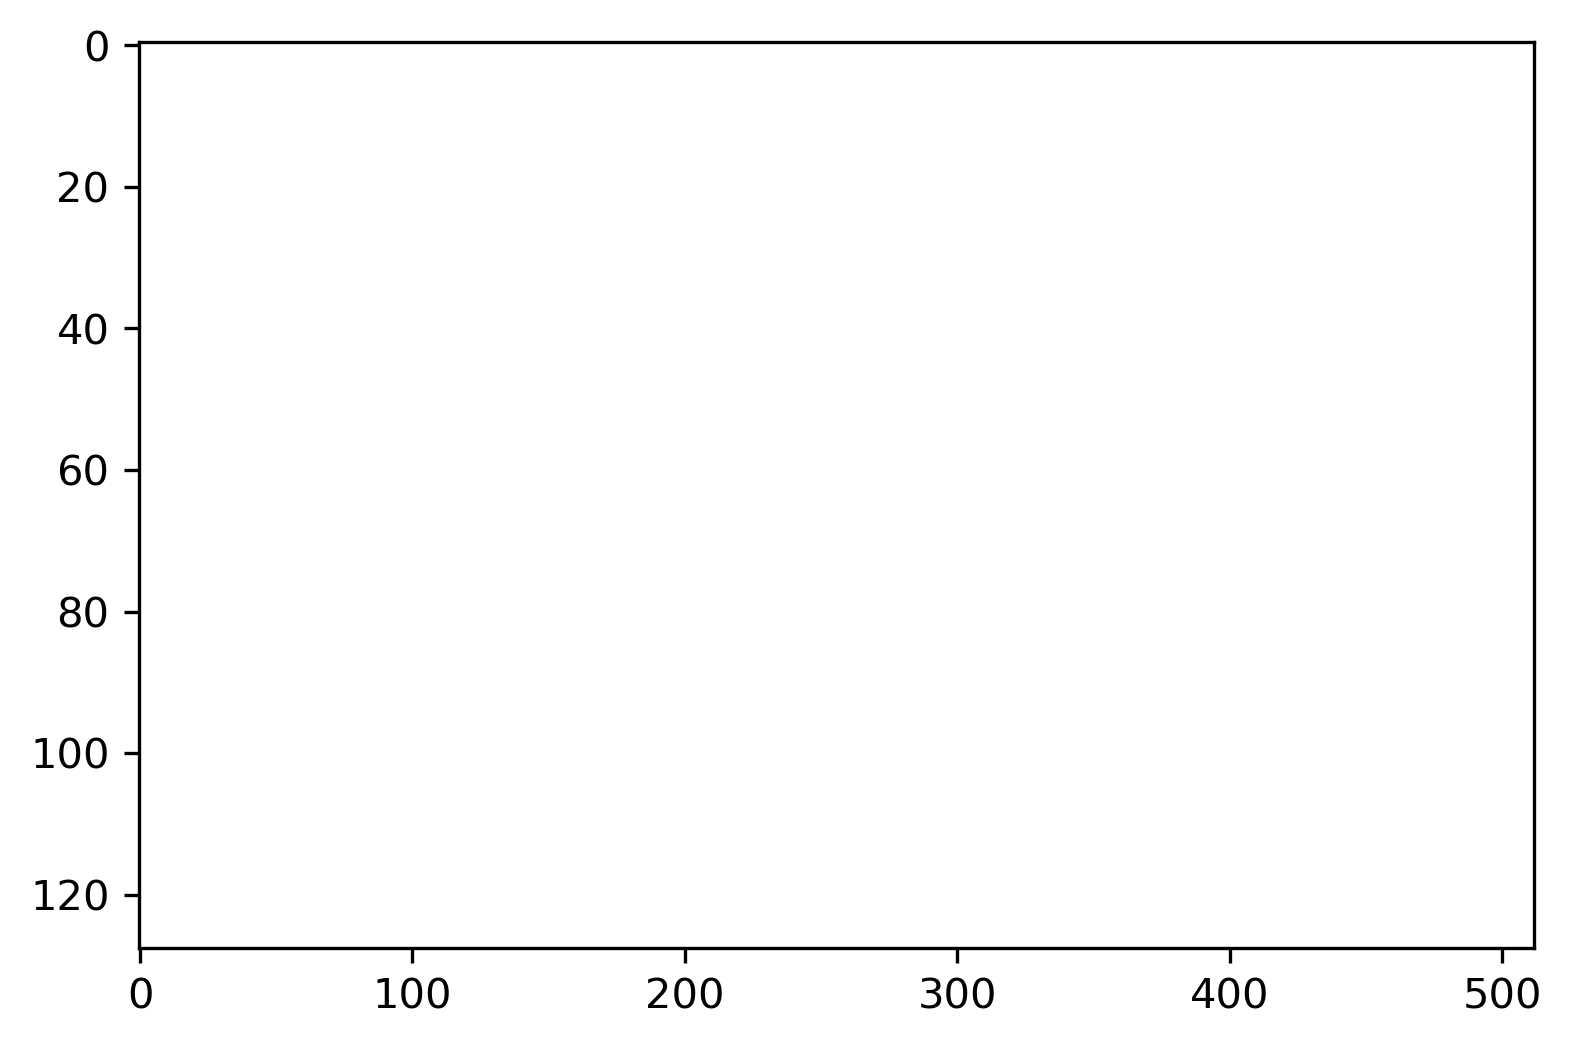

In [8]:
plt.figure(dpi=300)
plt.imshow(10*np.log10(D[:,-1,:])-GainADC,aspect='auto',vmin=-85,vmax=-65)

In [15]:
print(sis[6])

18


In [123]:
np.compress?

In [97]:
plt.subplot?